In [1]:
!wget -q https://www.dropbox.com/s/5wwskxctvcxiuea/MedNIST.tar.gz

In [2]:
import shutil
shutil.unpack_archive("MedNIST.tar.gz", "Dataset")

In [2]:
import numpy as np
import cv2
import os
import pickle
from google.colab.patches import cv2_imshow

In [3]:
class VPTree:

    """ VP-Tree data structure for efficient nearest neighbor search.
    The VP-tree is a data structure for efficient nearest neighbor
    searching and finds the nearest neighbor in O(log n)
    complexity given a tree constructed of n data points. Construction
    complexity is O(n log n).
    Parameters
    ----------
    points : Iterable
        Construction points.
    dist_fn : 
        Function taking to point instances as arguments and returning
        the distance between them.
    """

    def __init__(self, points, dist_fn):
        self.left = None
        self.right = None
        self.left_min = np.inf
        self.left_max = 0
        self.right_min = np.inf
        self.right_max = 0
        self.dist_fn = dist_fn

        if not len(points):
            raise ValueError('Points can not be empty.')

        # Vantage point is point furthest from parent vp.
        vp_i = 0
        self.vp = points[vp_i]
        points = np.delete(points, vp_i, axis=0)

        if len(points) == 0:
            return

        # Choose division boundary at median of distances.
        distances = [self.dist_fn(self.vp, p) for p in points]
        median = np.median(distances)

        left_points = []
        right_points = []
        for point, distance in zip(points, distances):
            if distance >= median:
                self.right_min = min(distance, self.right_min)
                if distance > self.right_max:
                    self.right_max = distance
                    right_points.insert(0, point) # put furthest first
                else:
                    right_points.append(point)
            else:
                self.left_min = min(distance, self.left_min)
                if distance > self.left_max:
                    self.left_max = distance
                    left_points.insert(0, point) # put furthest first
                else:
                    left_points.append(point)

        if len(left_points) > 0:
            self.left = VPTree(points=left_points, dist_fn=self.dist_fn)

        if len(right_points) > 0:
            self.right = VPTree(points=right_points, dist_fn=self.dist_fn)

    def _is_leaf(self):
        return (self.left is None) and (self.right is None)

    def get_nearest_neighbor(self, query):
        """ Get single nearest neighbor.
        
        Parameters
        ----------
        query : Any
            Query point.
        Returns
        -------
        Any
            Single nearest neighbor.
        """
        return self.get_n_nearest_neighbors(query, n_neighbors=1)[0]

    def get_n_nearest_neighbors(self, query, n_neighbors):
        """ Get `n_neighbors` nearest neigbors to `query`
        
        Parameters
        ----------
        query : Any
            Query point.
        n_neighbors : int
            Number of neighbors to fetch.
        Returns
        -------
        list
            List of `n_neighbors` nearest neighbors.
        """
        if not isinstance(n_neighbors, int) or n_neighbors < 1:
            raise ValueError('n_neighbors must be strictly positive integer')
        neighbors = _AutoSortingList(max_size=n_neighbors)
        nodes_to_visit = [(self, 0)]

        furthest_d = np.inf

        while len(nodes_to_visit) > 0:
            node, d0 = nodes_to_visit.pop(0)
            if node is None or d0 > furthest_d:
                continue

            d = self.dist_fn(query, node.vp)
            if d < furthest_d:
                neighbors.append((d, node.vp))
                furthest_d, _ = neighbors[-1]

            if node._is_leaf():
                continue

            if node.left_min <= d <= node.left_max:
                nodes_to_visit.insert(0, (node.left, 0))
            elif node.left_min - furthest_d <= d <= node.left_max + furthest_d:
                nodes_to_visit.append((node.left,
                                       node.left_min - d if d < node.left_min
                                       else d - node.left_max))

            if node.right_min <= d <= node.right_max:
                nodes_to_visit.insert(0, (node.right, 0))
            elif node.right_min - furthest_d <= d <= node.right_max + furthest_d:
                nodes_to_visit.append((node.right,
                                       node.right_min - d if d < node.right_min
                                       else d - node.right_max))

        return list(neighbors)

    def get_all_in_range(self, query, max_distance):
        """ Find all neighbours within `max_distance`.
        Parameters
        ----------
        query : Any
            Query point.
        max_distance : float
            Threshold distance for query.
        Returns
        -------
        neighbors : list
            List of points within `max_distance`.
        Notes
        -----
        Returned neighbors are not sorted according to distance.
        """
        neighbors = list()
        nodes_to_visit = [(self, 0)]

        while len(nodes_to_visit) > 0:
            node, d0 = nodes_to_visit.pop(0)
            if node is None or d0 > max_distance:
                continue

            d = self.dist_fn(query, node.vp)
            if d < max_distance:
                neighbors.append((d, node.vp))

            if node._is_leaf():
                continue

            if node.left_min <= d <= node.left_max:
                nodes_to_visit.insert(0, (node.left, 0))
            elif node.left_min - max_distance <= d <= node.left_max + max_distance:
                nodes_to_visit.append((node.left,
                                       node.left_min - d if d < node.left_min
                                       else d - node.left_max))

            if node.right_min <= d <= node.right_max:
                nodes_to_visit.insert(0, (node.right, 0))
            elif node.right_min - max_distance <= d <= node.right_max + max_distance:
                nodes_to_visit.append((node.right,
                                       node.right_min - d if d < node.right_min
                                       else d - node.right_max))

        return neighbors


class _AutoSortingList(list):

    """ Simple auto-sorting list.
    Inefficient for large sizes since the queue is sorted at
    each push.
    Parameters
    ---------
    size : int, optional
        Max queue size.
    """

    def __init__(self, max_size=None, *args):
        super(_AutoSortingList, self).__init__(*args)
        self.max_size = max_size

    def append(self, item):
        """ Append `item` and sort.
        Parameters
        ----------
        item : Any
            Input item.
        """
        super(_AutoSortingList, self).append(item)
        self.sort(key=lambda x: x[0])
        if self.max_size is not None and len(self) > self.max_size:
            self.pop()

In [4]:
winSize = (64,64)
blockSize = (16,16)
blockStride = (8,8)
cellSize = (16,16)
nbins = 9
derivAperture = 1
winSigma = -1.
histogramNormType = 0
L2HysThreshold = 0.2
gammaCorrection = 1
nlevels = 64
signedGradients = True

hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,histogramNormType,L2HysThreshold,gammaCorrection,nlevels,signedGradients)


In [5]:
image_dict = {}
def hash(feature,name,category):
    #feature = np.array(feature)
    feature = feature.flatten()
    feature = tuple(feature)
    l = image_dict.get(feature,[])
    l.append((name,category))
    image_dict[feature] = l

In [6]:
def euclidean(p1,p2):
    p1,p2 = np.array(p1),np.array(p2)
    return np.sqrt(np.sum(np.power(p2-p1,2)))

In [7]:
datapath = 'Dataset/MedNIST'
train_points,test_points,y_train,y_test = [],[],[],[]
labels = ['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']
label_dict = {'AbdomenCT': 0, 'BreastMRI': 1, 'ChestCT': 2, 'CXR': 3, 'Hand': 4, 'HeadCT': 5}

test_frac = 0.01
num_total = 58954
def dataloader(datapath):
    for category in os.listdir(datapath):
        path = os.path.join(datapath,category)
        i = 1
        for img_name in os.listdir(path):
            img = os.path.join(path,img_name)
            image = cv2.imread(img)
            features = hog.compute(image)
            hash(features,img,label_dict[category])
            if i%100 == 0:
                test_points.append(features)
                y_test.append(label_dict[category])
            else:
                train_points.append(features)
                y_train.append(label_dict[category])
            i += 1

In [8]:
dataloader(datapath)

In [33]:
print(len(train_points))
print(len(test_points))
print(len(test_points[1]))
print(test_points[1])

58365
589
441
[[0.35841915]
 [0.35841915]
 [0.35841915]
 [0.23034844]
 [0.35841915]
 [0.35841915]
 [0.35841915]
 [0.21002105]
 [0.35841915]
 [0.3544818 ]
 [0.3544818 ]
 [0.3544818 ]
 [0.259398  ]
 [0.3544818 ]
 [0.3544818 ]
 [0.3544818 ]
 [0.22264265]
 [0.3544818 ]
 [0.37795207]
 [0.37795207]
 [0.31784904]
 [0.11328431]
 [0.37795207]
 [0.37795207]
 [0.37795207]
 [0.15898497]
 [0.37795207]
 [0.40649262]
 [0.23854853]
 [0.40649262]
 [0.21083716]
 [0.40649262]
 [0.13756114]
 [0.31252286]
 [0.3421152 ]
 [0.40649262]
 [0.36198056]
 [0.2208486 ]
 [0.36198056]
 [0.36198056]
 [0.36198056]
 [0.17435554]
 [0.36198056]
 [0.36198056]
 [0.36198056]
 [0.37223333]
 [0.13130867]
 [0.37223333]
 [0.37223333]
 [0.37223333]
 [0.09558115]
 [0.37223333]
 [0.37223333]
 [0.37223333]
 [0.3525141 ]
 [0.3412094 ]
 [0.3525141 ]
 [0.3525141 ]
 [0.3525141 ]
 [0.10095081]
 [0.3525141 ]
 [0.3525141 ]
 [0.3525141 ]
 [0.3616813 ]
 [0.3616813 ]
 [0.3616813 ]
 [0.28670457]
 [0.3616813 ]
 [0.2726618 ]
 [0.3616813 ]
 [0.23

In [10]:
tree = VPTree(train_points,euclidean)

In [11]:
tree_path = 'HOGtree.pickle'
f = open(tree_path, "wb")
f.write(pickle.dumps(tree))
f.close()
           
directory_path = 'HOGimage_directory.pickle'
f = open(directory_path,"wb")
f.write(pickle.dumps(image_dict))
f.close()

In [12]:
from tqdm import tqdm
y_pred = []
y_top_five = []
for i in tqdm(range(len(test_points))):
    query_features = test_points[i]
    results = tree.get_n_nearest_neighbors(query_features,5)
    temp = []
    #h = results[1].flatten()
    #h = tuple(h)
    #resultPaths = image_dict.get(h,[])
    #category = resultPaths[0][1]
    #y_pred.append(category)
    for (d,h) in results:
        h  = h.flatten()
        h = tuple(h)
        resultPaths = image_dict.get(h,[])
        category = resultPaths[0][1]
        temp.append(category)
        #y_pred.append(category)
        y_top_five.append(temp)
    y_pred.append(temp[0])

100%|██████████| 589/589 [06:01<00:00,  1.63it/s]


In [35]:
#print(len(y_top_five))
#print(y_top_five[:5])
#print(y_test[:6])
#y_pred = []
#for i in range(len(y_top_five)):
#  if i%5 == 0:
#    y_pred.append(y_top_five[i][0])


2945
[[2, 2, 2, 2, 2], [2, 2, 2, 2, 2], [2, 2, 2, 2, 2], [2, 2, 2, 2, 2], [2, 2, 2, 2, 2]]
[2, 2, 2, 2, 2, 2]


In [37]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=labels, digits=4))

              precision    recall  f1-score   support

   AbdomenCT     1.0000    0.9900    0.9950       100
   BreastMRI     1.0000    1.0000    1.0000        89
         CXR     0.9901    1.0000    0.9950       100
     ChestCT     1.0000    1.0000    1.0000       100
        Hand     1.0000    1.0000    1.0000       100
      HeadCT     1.0000    1.0000    1.0000       100

    accuracy                         0.9983       589
   macro avg     0.9983    0.9983    0.9983       589
weighted avg     0.9983    0.9983    0.9983       589



In [38]:
print(y_test)

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [39]:
print(y_pred)

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [40]:
missclassified = []
for i in range(len(y_test)):
  if y_test[i] != y_pred[i]:
    missclassified.append((i,y_test[i],y_pred[i]))

In [41]:
print(missclassified)

[(304, 0, 2)]


In [43]:
print(y_test[300:310])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [44]:
print(y_pred[300:310])

[0, 0, 0, 0, 2, 0, 0, 0, 0, 0]


In [46]:
feature = test_points[304]
feature = feature.flatten()
feature = tuple(feature)
paths = image_dict.get(feature,[])
path = paths[0][0]

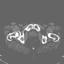

In [47]:
miss_image = cv2.imread(path)
cv2_imshow(miss_image)

In [49]:
print(path)
print(y_top_five[1520])

Dataset/MedNIST/AbdomenCT/000959.jpeg
[2, 2, 2, 2, 0]
